In [1]:
import jax.numpy as np

from jax.config import config
from jax import jit, grad, random
from jax.experimental import optimizers
from jax.experimental import stax
from jax.experimental.stax import Dense, Relu, LogSoftmax, Sigmoid, Tanh
import numpy.random as npr
import jax
from tqdm.notebook import tqdm
import numpy as onp
import itertools
from functools import partial
import matplotlib.pyplot as plt

from SC_IPFP.utils import log_kde_pdf_per_point, silvermans_rule

In [2]:
@partial(jit, static_argnums=(2))
def knn_log_prob(xTrain, xTest, k=30, w=0):
    """
    Can use this as an alternative to  log_kde_pdf_per_point, very noisy
    
    Approximate density p(x) ~ 1/kNN(x, {y_i})^d 
    the ln p(x) ~ - d * log kNN(x, {y_i})
    
    where kNN(x, {y_i}) is the distance of the kth nearest neighbour
    
    source: http://faculty.washington.edu/yenchic/18W_425/Lec7_knn_basis.pdf
    
    loss is very noisy, and goes down very slowly and un-monotnically
    
    Theres a lot of studies about these estimates for KL and entropy by Barnabas Poczos
    they might have refinements on the kNNN part. 
    
    w is a windowing parameter to take the mean of the kNN distance going backwards
    to the k-w nearest neighbours, to make things less noisy.
    
    This also mode collapses just goes for a mode basically straight away. Its strange
    
    """
    k = int(k)
    w = int(min(w, k ))
    
    n, d = xTrain.shape
    
    sq_distances = -2 * np.dot(xTrain, xTest.T) + np.sum(xTest**2,axis=1) + np.sum(xTrain**2,axis=1)[:, np.newaxis]
    sq_distances = np.clip(sq_distances, 0, None)
    sq_distances =  np.sort(sq_distances,0) #distances sorted in axis 0
        
    sq_distance = sq_distances[k,:]
#     print(sq_distance)
    return -(d * 0.5 * np.log(sq_distance))


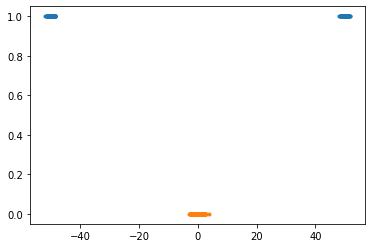

In [3]:
n = 900
n_2 = int(n / 3.0)

X1 = npr.randn(n).reshape(-1,1) + 0#50
X21 = 0.6 * npr.randn(450).reshape(-1,1) + 50
X22 =  0.6 * npr.randn(450).reshape(-1,1) - 50
# X23 =  0.6 * npr.randn(300).reshape(-1,1) - 30

X2 = np.concatenate((X22, X21), axis=0)

perm = onp.random.permutation(n)

X2 = X2[perm,:] 

plt.plot(X2.flatten(), [1] * n, '.')
plt.plot(X1.flatten(), [0] * n, '.')

In [5]:
def data_stream(X, batch_size = 200):
    rng =  npr.RandomState(0)

    
    num_batches = int(np.ceil(X.shape[0] / batch_size))
#     print(num_batches)

    num_train = X.shape[0]
    while True:
        perm = rng.permutation(num_train)
        for i in range(num_batches):
            batch_idx = perm[i * batch_size:(i + 1) * batch_size]
            yield X[batch_idx]
            
def create_network(dim, weights):
    model  = []
    for weight in weights:
        model.append(
            Dense(weight)
        )

        model.append(
            Relu
        )


    model.append(Dense(dim))

    init_random_params, predict = stax.serial(
       *model
    )
    return init_random_params, predict

In [37]:
def inner_loss(theta, batch):       
    batch_terminal_empirical = next(data_stream(X2))

    H = silvermans_rule(X2)
    
    
    Xt = b_forward(theta, batch)
    H_t = silvermans_rule(Xt)

    cross_entropy = -log_prob(Xt, batch_terminal_empirical, H)
    entropy = -log_prob(Xt, Xt, H_t)
#     cross_entropy = -log_prob(batch_terminal_empirical, Xt, H_t)

    J = np.mean(cross_entropy - entropy)
#     J = np.mean(cross_entropy )
    J = np.squeeze(J)

    return J

In [38]:
rng = jax.random.PRNGKey(100)

In [39]:

log_prob = log_kde_pdf_per_point
# log_prob = knn_log_prob

dim = 1

b_forward_init, b_forward = create_network(1, [20,20,20])
opt_init_f, opt_update_f, get_params_f = optimizers.adam(0.01)



_, init_params_f = b_forward_init(rng, (-1, dim))                                             
opt_state_f = opt_init_f(init_params_f)

batch_size = n
num_complete_batches_f, leftover_f = divmod(X1.shape[0], batch_size)

batches_f = data_stream(X1, batch_size=batch_size)

loss_f = []

theta_f = get_params_f(opt_state_f)

for i in tqdm(range(1000)):
    itercount = itertools.count()

    for _ in range(num_complete_batches_f):
        batch_f =  next(batches_f)
        params = get_params_f(opt_state_f)
        gradient = grad(inner_loss)(params, batch_f)
        opt_state_f = opt_update_f(i, gradient, opt_state_f)
        
    params = get_params_f(opt_state_f)
    lossf = inner_loss(params, batch_f)
    print(f"loss f {lossf}")
    loss_f.append(lossf)

loss f 16.830656051635742
loss f 16.402721405029297
loss f 16.083528518676758
loss f 15.812467575073242
loss f 15.572450637817383
loss f 15.356277465820312
loss f 15.149800300598145
loss f 14.944070816040039
loss f 14.736016273498535
loss f 14.522836685180664
loss f 14.30108642578125
loss f 14.07109546661377
loss f 13.828842163085938
loss f 13.570954322814941
loss f 13.29513931274414
loss f 12.999216079711914
loss f 12.681153297424316
loss f 12.339284896850586
loss f 11.971619606018066
loss f 11.576168060302734
loss f 11.151697158813477
loss f 10.69729232788086
loss f 10.212108612060547
loss f 9.695365905761719
loss f 9.146930694580078
loss f 8.568425178527832
loss f 7.96259880065918
loss f 7.332615852355957
loss f 6.682836532592773
loss f 6.019415378570557
loss f 5.351497650146484
loss f 4.690820217132568
loss f 4.051663875579834
loss f 3.4522223472595215
loss f 2.9135162830352783
loss f 2.458329916000366
loss f 2.108225107192993
loss f 1.8792763948440552
loss f 1.7745459079742432
los

loss f -0.04845612496137619
loss f -0.04890455678105354
loss f -0.04939556494355202
loss f -0.04985768720507622
loss f -0.050278741866350174
loss f -0.050724729895591736
loss f -0.05119714140892029
loss f -0.051633309572935104
loss f -0.05205263942480087
loss f -0.05250190198421478
loss f -0.0529509112238884
loss f -0.053370989859104156
loss f -0.05379214882850647
loss f -0.054230593144893646
loss f -0.054661527276039124
loss f -0.055072590708732605
loss f -0.055485956370830536
loss f -0.05591112747788429
loss f -0.056327786296606064
loss f -0.056731030344963074
loss f -0.05713662877678871
loss f -0.057548586279153824
loss f -0.0579511895775795
loss f -0.0583440363407135
loss f -0.058734215795993805
loss f -0.05912607163190842
loss f -0.05951809883117676
loss f -0.05990581959486008
loss f -0.060288090258836746
loss f -0.06066740304231644
loss f -0.06104646623134613
loss f -0.06142641603946686
loss f -0.06180321052670479
loss f -0.062174759805202484
loss f -0.0625423789024353
loss f -0.

loss f -0.10563049465417862
loss f -0.10568957775831223
loss f -0.10574771463871002
loss f -0.10581766813993454
loss f -0.105891153216362
loss f -0.105954609811306
loss f -0.10601282864809036
loss f -0.10607615113258362
loss f -0.10614585876464844
loss f -0.10621216148138046
loss f -0.10627229511737823
loss f -0.1063319742679596
loss f -0.10639600455760956
loss f -0.10646183043718338
loss f -0.10652480274438858
loss f -0.10658493638038635
loss f -0.10664449632167816
loss f -0.10670679807662964
loss f -0.10676931589841843
loss f -0.10683053731918335
loss f -0.10688973218202591
loss f -0.10694850981235504
loss f -0.10700902342796326
loss f -0.10707002878189087
loss f -0.10713045299053192
loss f -0.10718972235918045
loss f -0.10724783688783646
loss f -0.107306107878685
loss f -0.10736523568630219
loss f -0.1074243038892746
loss f -0.10748301446437836
loss f -0.10754118114709854
loss f -0.10759882628917694
loss f -0.10765644162893295
loss f -0.10771362483501434
loss f -0.10777100920677185


loss f -0.11657640337944031
loss f -0.11659034341573715
loss f -0.11662711203098297
loss f -0.11669015139341354
loss f -0.11677338182926178
loss f -0.11686407774686813
loss f -0.11694879829883575
loss f -0.11701195687055588
loss f -0.11705435812473297
loss f -0.11706849932670593
loss f -0.11706595867872238
loss f -0.11704595386981964
loss f -0.11702793091535568
loss f -0.11700578778982162
loss f -0.11700103431940079
loss f -0.11699773371219635
loss f -0.1170225739479065
loss f -0.11705352365970612
loss f -0.11710158735513687
loss f -0.11715936660766602
loss f -0.11721330881118774
loss f -0.11727017164230347
loss f -0.11730994284152985
loss f -0.1173405647277832
loss f -0.1173531636595726
loss f -0.11736508458852768
loss f -0.11736485362052917
loss f -0.1173623651266098
loss f -0.11735212802886963
loss f -0.11734601855278015
loss f -0.11733293533325195
loss f -0.11731177568435669
loss f -0.11730079352855682
loss f -0.11729010939598083
loss f -0.11730055510997772
loss f -0.11731048673391

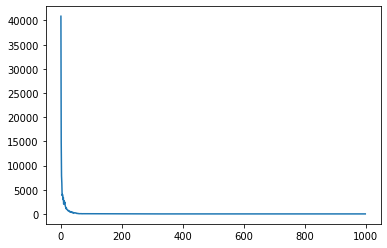

In [13]:
plt.plot(loss_f)

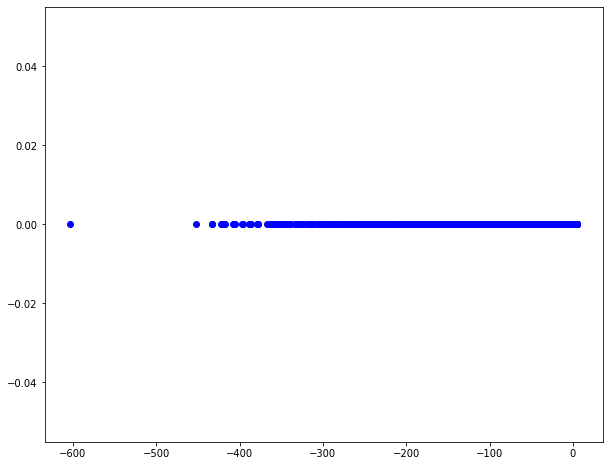

In [23]:
fig, axs = plt.subplots(1,  sharey=False, figsize=(10,8))


X =  b_forward(params, X1)
    
axs.plot(X.flatten(), [0] * n , 'ob', )

In [24]:
HX = silvermans_rule(X)

In [25]:
-log_prob(X2, X, HX).mean()

DeviceArray(5.592813, dtype=float32)

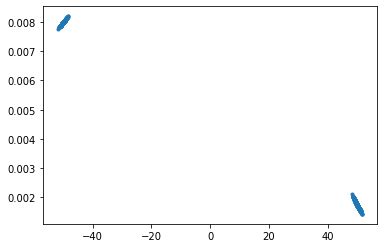

In [27]:
xplt.plot(X2, np.exp(log_prob(X2, X, HX)), '.')

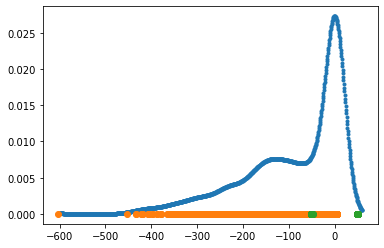

In [36]:
xx = np.linspace(-600,60, 1000).reshape(-1,1)
plt.plot(xx, np.exp(log_prob(xx, X, HX)), '.')
plt.plot(X.flatten(), [0] * len(X.flatten()), 'o')
plt.plot(X2.flatten(), [0] * len(X2.flatten()), 'o')